<a href="https://colab.research.google.com/github/dgalassi99/quant-trading-self-study/blob/main/01_foundations/W2_Moving_Average_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a MAs Crossing Strategy

We select different securities from stocks, to crypto and commodities

In [2]:
#importing main libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [161]:
#let's download data for the desired securities
tickers = ['GOOGL', 'NVDA', 'XOM', 'QQQ', 'VTI', 'ETH-USD', 'GLD', 'USO', 'EURUSD=X']
start_date = '2020-01-01'
end_date = '2025-01-01'
#create a dictionary where key = ticker name and value is ticker data for each tick in tickers
data = {}
for tik in tickers:
  data[tik] = yf.download(tik, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [36]:
#fast checking if there are missing values
for tik in tickers:
  print(data[tik].isna().sum())

Price   Ticker
Close   GOOGL     0
High    GOOGL     0
Low     GOOGL     0
Open    GOOGL     0
Volume  GOOGL     0
dtype: int64
Price   Ticker
Close   NVDA      0
High    NVDA      0
Low     NVDA      0
Open    NVDA      0
Volume  NVDA      0
dtype: int64
Price   Ticker
Close   QQQ       0
High    QQQ       0
Low     QQQ       0
Open    QQQ       0
Volume  QQQ       0
dtype: int64
Price   Ticker
Close   VTI       0
High    VTI       0
Low     VTI       0
Open    VTI       0
Volume  VTI       0
dtype: int64
Price   Ticker 
Close   ETH-USD    0
High    ETH-USD    0
Low     ETH-USD    0
Open    ETH-USD    0
Volume  ETH-USD    0
dtype: int64
Price   Ticker
Close   GLD       0
High    GLD       0
Low     GLD       0
Open    GLD       0
Volume  GLD       0
dtype: int64
Price   Ticker
Close   USO       0
High    USO       0
Low     USO       0
Open    USO       0
Volume  USO       0
dtype: int64


In [137]:
#now we will select just a ticker here but you can change it to see how
#this simple strategy applies to different commodities
tik = 'ETH-USD'
#we will just keep close and volume as we assume the strategy is not on the short time frame
#hence we will not 'trade intraday
df = data[tik][['Close', 'Volume']]
#dropping the outer level of the columns to avoid having a multiindex dataset
df = df.droplevel(level=1, axis=1)

In [138]:
#calculate 50,200 period MAs
df['ma20'] = df['Close'].rolling(20).mean()
df['ma50'] = df['Close'].rolling(50).mean()
#dropping the NaN rows created by the rolling function
df = df.dropna()

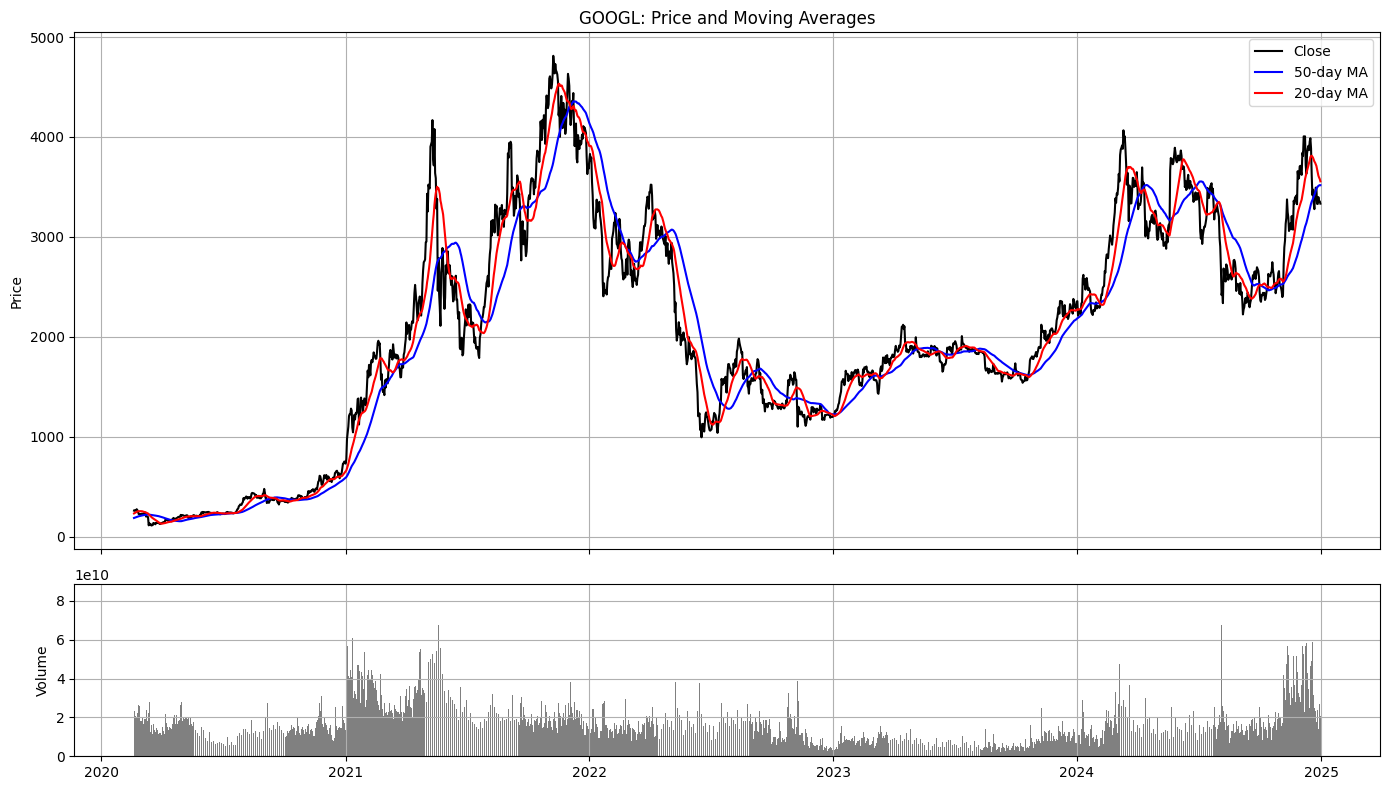

In [139]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8),
    gridspec_kw={'height_ratios': [3, 1]},sharex=True)
# --- Main price chart
ax1.plot(df['Close'], label='Close', color='black')
ax1.plot(df['ma50'], label='50-day MA', color='blue')
ax1.plot(df['ma20'], label='20-day MA', color='red')
ax1.set_title('GOOGL: Price and Moving Averages')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)
# --- Volume chart
ax2.bar(df.index, df['Volume'], color='gray')
ax2.set_ylabel('Volume')
ax2.grid(True)
# --- adjusting the plot
plt.tight_layout()
plt.show()

In [140]:
#first trading simple strategy

#long when the short frame MA breaks the long frame one
#short when the break occurs in the opposite direction

#create a column such that 1 if ma20 > ma50, 0 otherwise
df['position'] = (df['ma20'] > df['ma50']).astype(int)
#get crossover signals by checking when the position changes
df['crossover_signal'] = df['position'].diff()
#drop NaNs from diff (first row will be NaN)
df = df.dropna(subset=['crossover_signal'])

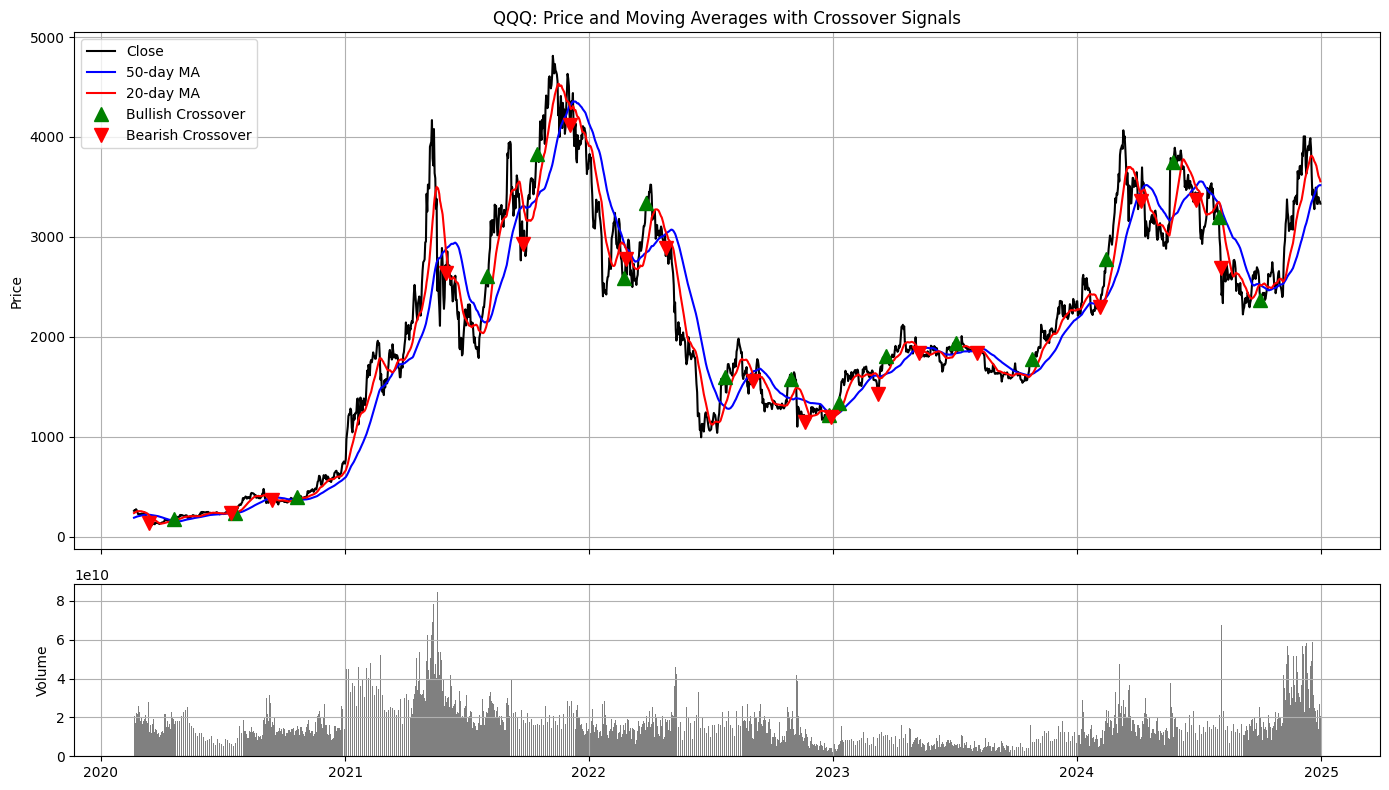

In [141]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8),
    gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# --- Main price chart
ax1.plot(df['Close'], label='Close', color='black')
ax1.plot(df['ma50'], label='50-day MA', color='blue')
ax1.plot(df['ma20'], label='20-day MA', color='red')

#add crossover signals to price chart
#bullish
bullish = df[df['crossover_signal'] == 1]
ax1.plot(bullish.index, df.loc[bullish.index, 'Close'],
         '^', markersize=10, color='green', label='Bullish Crossover')

#bearish
bearish = df[df['crossover_signal'] == -1]
ax1.plot(bearish.index, df.loc[bearish.index, 'Close'],
         'v', markersize=10, color='red', label='Bearish Crossover')

ax1.set_title('QQQ: Price and Moving Averages with Crossover Signals')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)

# --- Volume chart
ax2.bar(df.index, df['Volume'], color='gray')
ax2.set_ylabel('Volume')
ax2.grid(True)

# --- Adjust layout
plt.tight_layout()
plt.show()


In [142]:
#let's implement the first strategy:
#1. unidirectional (long-only)
#2. enter on a positive cross-over (bullish signal) and exit on a negative one (bearish signal)
#3. calcualte returns and compare with a buy&hold

#daily returns
df['daily_return'] = df['Close'].pct_change()
#strategy returns only active when in position
df['strategy_return'] = df['daily_return'] * df['position']

#cumulative returns for buy & hold adn crossover strategy
df['cumulative_buy_hold'] = (1 + df['daily_return']).cumprod()
df['cumulative_strategy'] = (1 + df['strategy_return']).cumprod()

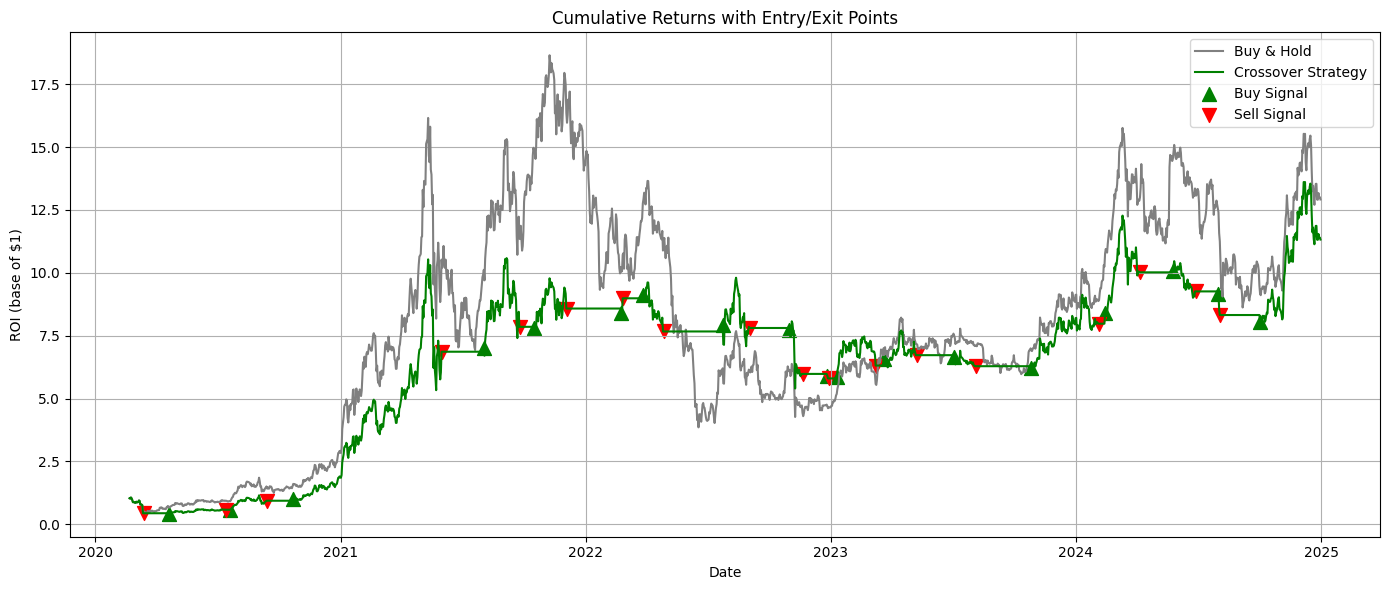

In [143]:
plt.figure(figsize=(14,6))
#cumulative returns
plt.plot(df.index, df['cumulative_buy_hold'], label='Buy & Hold', color='gray')
plt.plot(df.index, df['cumulative_strategy'], label='Crossover Strategy', color='green')
#mark bullish crossovers (entry signals)
entry_points = df[df['crossover_signal'] == 1]
plt.scatter(entry_points.index, df.loc[entry_points.index, 'cumulative_strategy'],
            marker='^', color='green', label='Buy Signal', s=100)
#mark bearish crossovers (exit signals)
exit_points = df[df['crossover_signal'] == -1]
plt.scatter(exit_points.index, df.loc[exit_points.index, 'cumulative_strategy'],
            marker='v', color='red', label='Sell Signal', s=100)
plt.title('Cumulative Returns with Entry/Exit Points')
plt.xlabel('Date')
plt.ylabel('ROI (base of $1)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


As you can notice the buy&hold strategy looks much better. But we need to consider we are analyzing a past-performance chart and the 5 years analyzed are very bullish. In order to study something more informative I will run more simulations on the same chart where I randomized the starting date so that we remove this bias.

In [144]:
import random
results = []

# List of valid start indices (skip first 100 for stable MA)
valid_indices = df.index[100:-100]


for _ in range(10000):
    #pick random start and ending period and slice teh dataset in this timeframe
    random_start, random_end = sorted(random.sample(list(valid_indices), 2))
    df_slice = df.loc[random_start:random_end].copy()
    #recalculate the MAs to avoid lookahead bias
    df_slice['ma20'] = df_slice['Close'].rolling(window=20).mean()
    df_slice['ma50'] = df_slice['Close'].rolling(window=50).mean()

    #define the singals: 1 for bullish crossover, -1 for bearish, 0 otherwise
    df_slice['position'] = 0
    df_slice.loc[df_slice['ma20'] > df_slice['ma50'], 'position'] = 1

    #counting how many operations have been done
    df_slice['position_change'] = df_slice['position'].diff().ne(0).astype(int)  # Count position changes
    num_operations = df_slice['position_change'].sum()

    #daily returns, strategy returns and cumulative returns
    df_slice['daily_return'] = df_slice['Close'].pct_change()
    df_slice['strategy_return'] = df_slice['daily_return'] * df_slice['position']
    df_slice['cumulative_buy_hold'] = (1 + df_slice['daily_return']).cumprod()
    df_slice['cumulative_strategy'] = (1 + df_slice['strategy_return']).cumprod()
    #store results
    final_bh = df_slice['cumulative_buy_hold'].iloc[-1]
    final_strat = df_slice['cumulative_strategy'].iloc[-1]
    entry_price = df_slice['Close'].iloc[0]
    exit_price = df_slice['Close'].iloc[-1]
    results.append((final_bh, final_strat,random_start,random_end,entry_price,exit_price,num_operations))


In [145]:
results = pd.DataFrame(results, columns=['Buy & Hold', 'Crossover Strategy','Start','End','Entry Price','Exit Price','Operativity'])
results['Trading Days'] = results['End'] - results['Start']
#results[['Buy & Hold', 'Crossover Strategy','Trading Days']].describe()
sharpe_crossover = results['Crossover Strategy'].mean() / results['Crossover Strategy'].std()
sharpe_bnh = results['Buy & Hold'].mean() / results['Buy & Hold'].std()
sharpe_compare= (results['Crossover Strategy'].mean()-results['Buy & Hold'].mean()) / results['Buy & Hold'].std()
print(f'Sharpe Ratio Crossover: {sharpe_crossover}')
print(f'Sharpe Ratio Buy & Hold: {sharpe_bnh}')
print(f'Sharpe Ratio Compare: {sharpe_compare}')


Sharpe Ratio Crossover: 0.8729515540157171
Sharpe Ratio Buy & Hold: 0.8521173571712519
Sharpe Ratio Compare: -0.05153470367239345


In [146]:
results[['Buy & Hold', 'Crossover Strategy','Entry Price','Exit Price','Operativity']].describe().round(4)

,Buy & Hold,Crossover Strategy,Entry Price,Exit Price,Operativity
count,10000.0000,10000.0000,10000.0000,10000.0000,10000.0000
mean,2.4633,2.3143,1843.3151,2309.4294,11.8027
std,2.8908,2.6511,1170.9013,859.2748,8.3299
min,0.2136,0.5711,222.9598,225.3871,1.0000
25%,0.8444,0.9393,659.2979,1647.8381,4.0000
50%,1.2939,1.1376,1772.7856,2084.4131,10.0000
75%,2.5659,1.7826,2682.8540,3014.6482,18.0000
max,20.0956,17.9238,4812.0874,4812.0874,33.0000


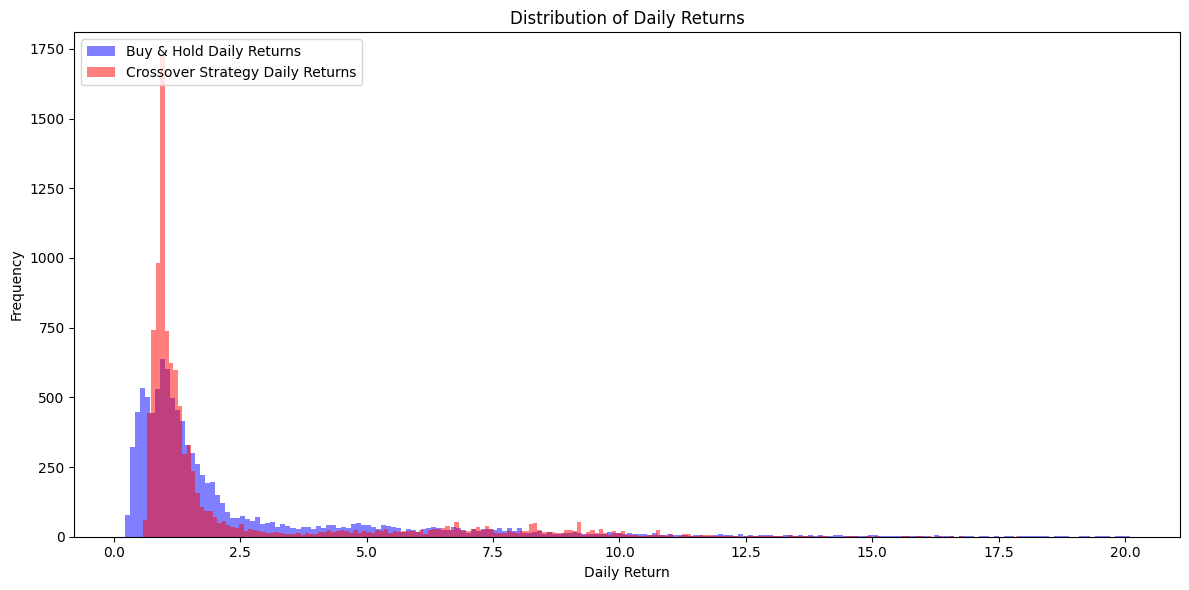

In [147]:
#distributions of daily returns
plt.figure(figsize=(12, 6))
plt.hist(results['Buy & Hold'].dropna(), bins=200, alpha=0.5, label="Buy & Hold Daily Returns", color='blue')
plt.hist(results['Crossover Strategy'].dropna(), bins=200, alpha=0.5, label="Crossover Strategy Daily Returns", color='red')
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [162]:
#let's now repeat for more tickers to have more distributions all togheter and compare it on different securities
#create a dictionary where key = ticker name and value is ticker data for each tick in tickers
data = {}
for tik in tickers:
  data[tik] = yf.download(tik, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [163]:
results_dict = {}  #store results for each DataFrame

#change this number to run more simulations, up to 1000 simultations runs in short time (max 1-2 mins)
num_simulations = 500

#iterate over each DataFrame in the 'data' dictionary
for key, df in data.items():
    results = []
    valid_indices = df.index[100:-100]
    #run the simulation for the current DataFrame
    for _ in range(num_simulations):
        random_start, random_end = sorted(random.sample(list(valid_indices), 2))
        df_slice = df.loc[random_start:random_end].copy()
        df_slice['ma20'] = df_slice['Close'].rolling(window=20).mean()
        df_slice['ma50'] = df_slice['Close'].rolling(window=50).mean()
        df_slice['position'] = 0
        df_slice.loc[df_slice['ma20'] > df_slice['ma50'], 'position'] = 1
        df_slice['position_change'] = df_slice['position'].diff().ne(0).astype(int)
        num_operations = df_slice['position_change'].sum()
        df_slice['daily_return'] = df_slice['Close'].pct_change()
        df_slice['strategy_return'] = df_slice['daily_return'] * df_slice['position']
        df_slice['cumulative_buy_hold'] = (1 + df_slice['daily_return']).cumprod()
        df_slice['cumulative_strategy'] = (1 + df_slice['strategy_return']).cumprod()
        final_bh = df_slice['cumulative_buy_hold'].iloc[-1]
        final_strat = df_slice['cumulative_strategy'].iloc[-1]
        entry_price = df_slice['Close'].iloc[0]
        exit_price = df_slice['Close'].iloc[-1]
        results.append((final_bh, final_strat, random_start, random_end, entry_price, exit_price, num_operations))

#store the results for the current DataFrame in the 'results_dict'
    results_dict[key] = results


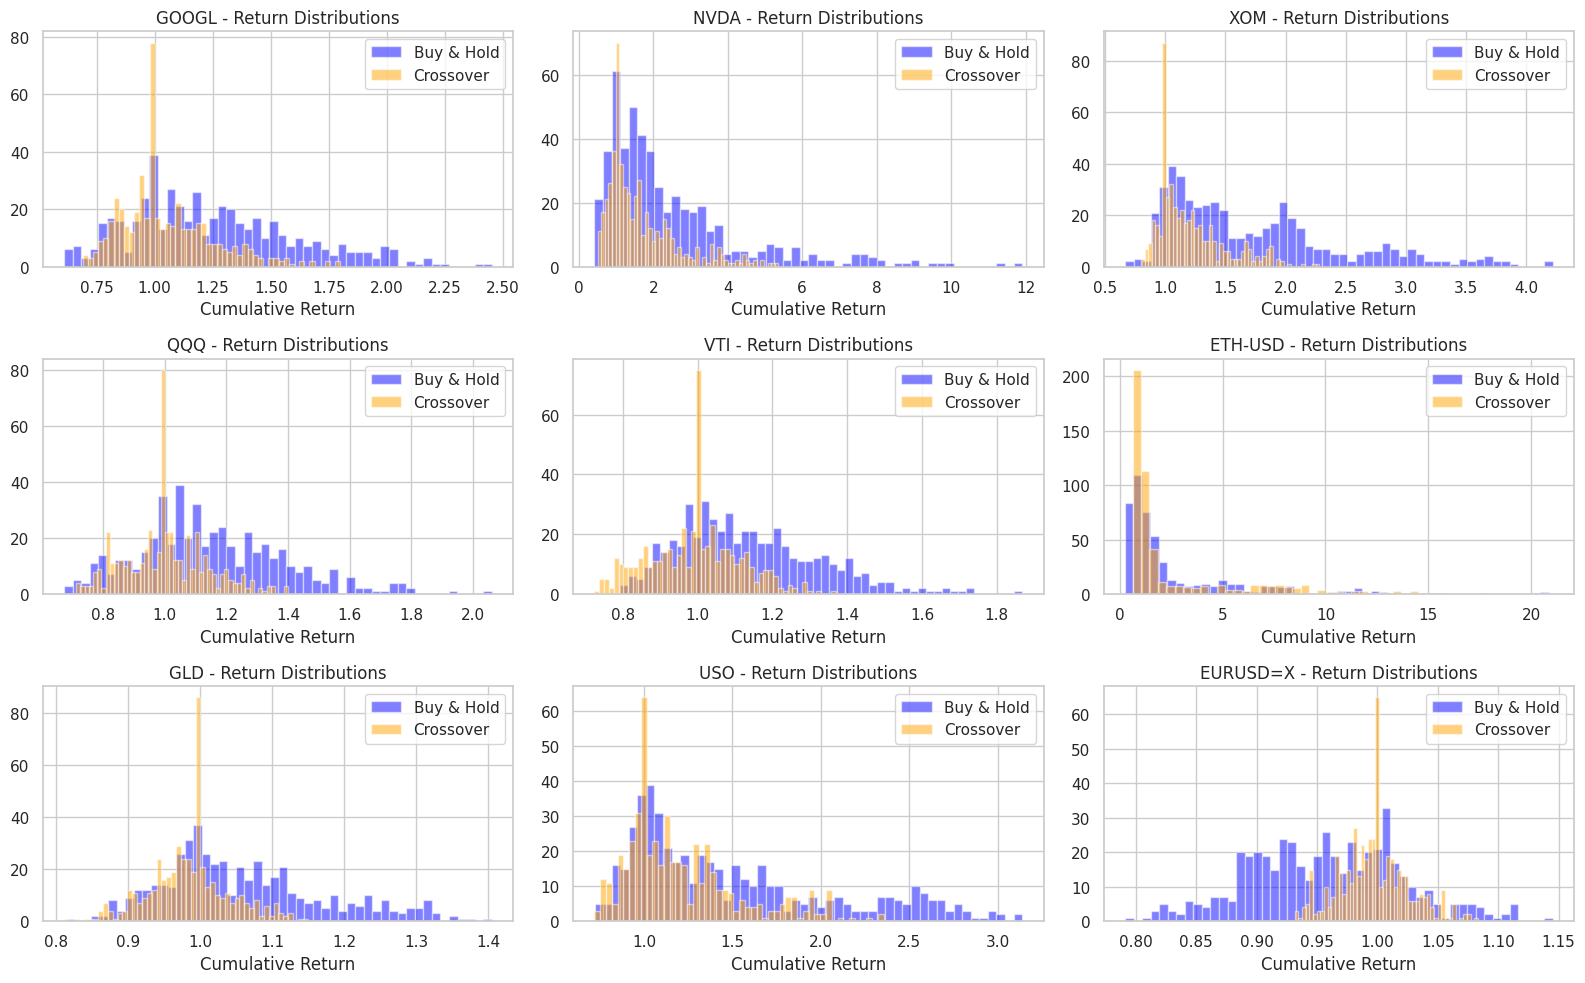

In [164]:
#plotting the distributions of returns for all the tickers selected at the beginning
sns.set(style="whitegrid")

num_keys = len(results_dict)
rows = int(np.ceil(num_keys ** 0.5))
cols = int(np.ceil(num_keys / rows))
fig, axes = plt.subplots(rows, cols, figsize=(16, 10))
axes = axes.flatten()
#loop over each key and plot distributions
for i, (key, results) in enumerate(results_dict.items()):
    df_results = pd.DataFrame(results, columns=['Buy & Hold', 'Crossover Strategy','Start', 'End', 'Entry Price', 'Exit Price', 'Operativity'])
    ax = axes[i]
    ax.hist(df_results['Buy & Hold'], bins=50, alpha=0.5, label='Buy & Hold', color='blue')
    ax.hist(df_results['Crossover Strategy'], bins=50, alpha=0.5, label='Crossover', color='orange')
    ax.set_title(f'{key} - Return Distributions')
    ax.legend()
    ax.set_xlabel('Cumulative Return')
plt.tight_layout()
plt.show()

Repeating with MA 20/100

In [ ]:
results_dict = {}  #store results for each DataFrame

#change this number to run more simulations, up to 1000 simultations runs in short time (max 1-2 mins)
num_simulations = 500

#iterate over each DataFrame in the 'data' dictionary
for key, df in data.items():
    results = []
    valid_indices = df.index[100:-100]
    #run the simulation for the current DataFrame
    for _ in range(num_simulations):
        random_start, random_end = sorted(random.sample(list(valid_indices), 2))
        df_slice = df.loc[random_start:random_end].copy()
        df_slice['ma20'] = df_slice['Close'].rolling(window=20).mean()
        df_slice['ma50'] = df_slice['Close'].rolling(window=50).mean()
        df_slice['position'] = 0
        df_slice.loc[df_slice['ma20'] > df_slice['ma50'], 'position'] = 1
        df_slice['position_change'] = df_slice['position'].diff().ne(0).astype(int)
        num_operations = df_slice['position_change'].sum()
        df_slice['daily_return'] = df_slice['Close'].pct_change()
        df_slice['strategy_return'] = df_slice['daily_return'] * df_slice['position']
        df_slice['cumulative_buy_hold'] = (1 + df_slice['daily_return']).cumprod()
        df_slice['cumulative_strategy'] = (1 + df_slice['strategy_return']).cumprod()
        final_bh = df_slice['cumulative_buy_hold'].iloc[-1]
        final_strat = df_slice['cumulative_strategy'].iloc[-1]
        entry_price = df_slice['Close'].iloc[0]
        exit_price = df_slice['Close'].iloc[-1]
        results.append((final_bh, final_strat, random_start, random_end, entry_price, exit_price, num_operations))

#store the results for the current DataFrame in the 'results_dict'
    results_dict[key] = results
